In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras

Exercise 9.

In [2]:
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train, y_train = x_train_full[5000:], y_train_full[5000:]
x_valid, y_valid = x_train_full[:5000], y_train_full[:5000]

In [3]:
train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len(x_train))
valid_set = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [4]:
from tensorflow.train import Example, Feature, Features, BytesList, Int64List

def create_example(image, label):
    image_data = tf.io.serialize_tensor(image)
    return Example(features=Features(feature={
        'image': Feature(bytes_list=BytesList(value=[image_data.numpy()])),
        'label': Feature(int64_list=Int64List(value=[label])),
    }))

In [5]:
for image, label in valid_set.take(1):
    print(create_example(image, label))

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\010\004\022\010\022\002\010\034\022\002\010\034\"\220\006\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\001\000\000\rI\000\000\001\004\000\000\000\000\001\001\000\000\000\000\000\000\000\000\000\000\000\000\000\003\000$\210\177>6\000\000\000\001\003\004\000\000\003\000\000\000\000\000\000\000\000\000\000\000\000\006\000f\314\260\206\220{\027\000\000\000\000\014\n\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\233\354\317\262k\234\241m@\027M\202H\017\000\000\000\000\000\000\000\000\000\000\000\001\000E\317\337\332\330\330\243\177yz\222\215X\254B\000\000\00

In [6]:
from contextlib import ExitStack

def write_tfrecords(name, dataset, n_shards=10):
    paths = [f'{name}-{index:05d}-of-{n_shards:05d}.tfrecord' 
             for index in range(n_shards)]
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path)) 
                   for path in paths]
        for index, (image, label) in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image, label)
            writers[shard].write(example.SerializeToString())
    return paths

In [7]:
train_filepaths = write_tfrecords('fashion_mnist.train', train_set)
valid_filepaths = write_tfrecords('fashion_mnist.valid', valid_set)
test_filepaths = write_tfrecords('fashion_mnist.test', test_set)

In [8]:
def preprocess(tfrecord):
    feature_descriptions = {
        'image': tf.io.FixedLenFeature([], tf.string, default_value=''),
        'label': tf.io.FixedLenFeature([], tf.int64, default_value=-1),
    }
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)
    image = tf.io.parse_tensor(example['image'], out_type=tf.uint8)
    image = tf.reshape(image, shape=[28, 28])
    return image, example['label']

In [9]:
def mnist_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None, 
                  n_parse_threads=5, batch_size=32, cache=True):
    dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [10]:
train_set = mnist_dataset(train_filepaths, shuffle_buffer_size=60000)
valid_set = mnist_dataset(valid_filepaths)
test_set = mnist_dataset(test_filepaths)

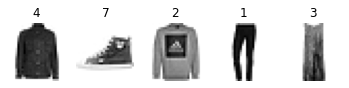

In [11]:
import matplotlib.pyplot as plt

for x, y in train_set.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(x[i].numpy(), cmap='binary')
        plt.axis('off')
        plt.title(str(y[i].numpy()))

In [12]:
class Standardization(keras.layers.Layer):
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, axis=0, keepdims=True)
        self.stds_ = np.std(data_sample, axis=0, keepdims=True)
    def call(self, inputs):
        return (inputs - self.means_) / (self.stds_ + keras.backend.epsilon())

In [13]:
standardization = Standardization(input_shape=[28, 28])
sample_image_batches = train_set.take(100).map(lambda image, label: image)
sample_images = np.concatenate(list(sample_image_batches.as_numpy_iterator()), 
                               axis=0).astype(np.float32)
standardization.adapt(sample_images)

In [14]:
model = keras.models.Sequential([
    standardization,
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax'),
])

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='nadam', metrics=['acc'])

In [15]:
from datetime import datetime

logs = os.path.join(os.curdir, 'my_logs', 'run_' + datetime.now().strftime('%Y%m%d_%H%M%S'))
tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=logs, histogram_freq=1, profile_batch=10)

model.fit(train_set, epochs=10, validation_data=valid_set, callbacks=[tensorboard_cb])

Epoch 1/10
1719/1719 [==============================] - 3s 1ms/step - loss: 453.5057 - acc: 0.8436 - val_loss: 2370.3655 - val_acc: 0.8636
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 696.3561 - acc: 0.8796 - val_loss: 512.6914 - val_acc: 0.8798
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 193.9449 - acc: 0.8931 - val_loss: 121.3749 - val_acc: 0.8826
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 208.1399 - acc: 0.9001 - val_loss: 589.7313 - val_acc: 0.8888
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 364.1850 - acc: 0.9089 - val_loss: 238.1173 - val_acc: 0.8826
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 204.6745 - acc: 0.9143 - val_loss: 172.7952 - val_acc: 0.8822
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 41.0469 - acc: 0.9192 - val_loss: 92.2749 - val_acc: 0.8870
Epoch 8/10
1719/1719 [=============

In [16]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

Reusing TensorBoard on port 6006 (pid 9228), started 0:22:10 ago. (Use '!kill 9228' to kill it.)